<a href="https://colab.research.google.com/github/Nicolas-Nav/DeepLearning/blob/main/Entrega3_1_DeepLearning_listo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementar una red neuronal recurrente

Autores: Nicolas Navarro y Gabriela Sandoval

Correo Electrónico: ni.navarroa@duocuc.cl y gab.sandoval@duocuc.cl

Fecha de creacion: Junio 2026

Versión: 1.0

El objetivo de este trabajo es explorar y evaluar diferentes arquitecturas de redes neuronales recurrentes para el modelado de texto, específicamente orientadas a predecir secuencias de caracteres en el contexto del texto Don Quijote de la Mancha. Se busca determinar qué configuración de red ofrece un mejor desempeño en términos de pérdida (loss), coherencia y capacidad de generalización, considerando distintas estrategias de diseño y ajuste de hiperparámetros.

Para ello, se experimentó con modelos de tipo RNN y LSTM, comparando su rendimiento al ser entrenados carácter a carácter sobre secuencias codificadas mediante one-hot encoding. A lo largo del proceso, se aplicaron diferentes modificaciones en los modelos, como el uso de capas bidireccionales, ajustes en el tamaño del lote (batch size) y aplicación de técnicas de regularización como dropout, con el fin de observar su impacto en la pérdida y la calidad del texto generado. Además, se incorporó el uso de temperatura en la generación de texto para evaluar el comportamiento del modelo frente a diferentes niveles de aleatoriedad.

A través de una comparación sistemática de los resultados, se busca identificar la arquitectura más adecuada para esta tarea de predicción de secuencias, justificando las decisiones tomadas con base en el análisis de las métricas obtenidas.

##RNN vs LSTM

Una RNN (Red Neuronal Recurrente) es un tipo de red diseñada para procesar datos secuenciales, como texto o series temporales, permitiendo que la información se propague de un paso de tiempo al siguiente a través de una "memoria interna". Sin embargo, al entrenar RNN tradicionales, se enfrentan al problema del desvanecimiento del gradiente, lo que hace que olviden información a medida que la secuencia se alarga. Para resolver esto, se introdujo la LSTM (Long Short-Term Memory), una variante de RNN que regulan el flujo de información y permiten conservar datos relevantes durante más tiempo. La principal diferencia entre una RNN y una LSTM radica en su capacidad para manejar dependencias a largo plazo: mientras que las RNN simples tienden a olvidar rápidamente la información debido al problema del desvanecimiento del gradiente, las LSTM incorporan una arquitectura más compleja con puertas de entrada, olvido y salida que controlan el flujo de información dentro de una celda de memoria. Esto les permite retener información relevante por períodos mucho más largos. Por esta razón, las LSTM son generalmente mejores que las RNN tradicionales en tareas como el modelado de lenguaje, traducción automática o cualquier secuencia donde el contexto a largo plazo sea crucial.

## 0. Importaciones y funciones

Antes de iniciar con la construcción y entrenamiento del modelo, es necesario importar las librerías que permitirán realizar el procesamiento de datos, la definición de redes neuronales, el entrenamiento y la visualización de resultados.

In [ ]:
import numpy as np
import keras
import random
import matplotlib.pyplot as plt
import unicodedata
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional

A continuación, se define una función que permite visualizar el comportamiento del modelo durante el entrenamiento. Esta herramienta gráfica facilita el análisis de la pérdida (loss) a lo largo de las épocas.

In [ ]:
def graficar_historial_entrenamiento(hist):
    """
    Grafica la pérdida y la precisión del entrenamiento y validación a lo largo de las épocas.

    Parámetros:
    hist -- Objeto History devuelto por el método fit() de un modelo Keras.

    ###Dejo el comentario igual como lo hace la profe en sus notes
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    epocas = range(1, len(hist.history['loss']) + 1)

    axs[0].plot(epocas, hist.history['loss'], label="train")
    axs[0].set_title('Pérdida', fontsize=14, fontweight="bold")
    axs[0].set_xlabel('Época', fontsize=12, fontweight="bold")
    axs[0].legend()

    plt.tight_layout()
    plt.show()


Para evaluar cuál de los modelos entrenados ofrece un mejor rendimiento, se define una función que permite comparar, a través de gráficos de barra, la pérdida (loss) entre las distintas configuraciones. Esto es útil para tomar decisiones informadas sobre cuál arquitectura o ajuste de hiperparámetros produce mejores resultados, según esta métrica.

In [ ]:
def graficar_comparacion_modelos(historiales, nombres_modelos):
    """
    Crea un gráfico de barras comparando métricas finales (accuracy, val_accuracy, loss, val_loss) de varios modelos.

    Parámetros:
    historiales -- Lista de objetos history (dict o hist.history de Keras).
    nombres_modelos -- Lista de nombres que identifican a cada modelo (str), en el mismo orden que los historiales.
    """
    if len(historiales) != len(nombres_modelos):
        raise ValueError("Las listas de historiales y nombres de modelos deben tener la misma longitud.")

    metricas = ['loss']
    nombres_metricas = ['Loss']

    data = {'Métrica': nombres_metricas}

    for nombre, hist in zip(nombres_modelos, historiales):
        valores = [hist[m][-1] if m in hist else None for m in metricas]
        data[nombre] = valores

    df_comparacion = pd.DataFrame(data)

    # Configuración del gráfico
    plt.figure(figsize=(18, 6))
    bar_width = 0.8 / len(nombres_modelos)
    index = range(len(nombres_metricas))

    # Dibujar las barras para cada modelo
    for i, nombre in enumerate(nombres_modelos):
        posiciones = [j + (i - len(nombres_modelos)/2) * bar_width + bar_width/2 for j in index]
        barras = plt.bar(posiciones, df_comparacion[nombre], bar_width, label=nombre)
        for bar in barras:
            height = bar.get_height()
            if height is not None:
                plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=8)

    # Etiquetas y título
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title('Comparación de Métricas entre Modelos')
    plt.xticks(index, nombres_metricas, rotation=45)
    plt.legend(title='Modelos', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return df_comparacion

In [ ]:
def metricas(history):
    return {
        'Train Loss': f"{history.history['loss'][-1]:.4f}",
    }

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [ ]:
path = keras.utils.get_file(
    fname="don_quijote.txt",
    origin=" https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/textos/Don_Quijote_de_la_Mancha.txt"
)

2151176/2151176 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente en el preprocesamiento, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo, ademas de retirar simbolos especiales y dejar las letras con tilde o similiar a su version normal (de modo que todas las letras sean menos demandantes y el modelo no necesite diferenciar entre minúsculas y mayúsculas o variantes de estas letras).

In [ ]:
# Abrir y leer el contenido
with open(path, 'r', encoding='utf-8') as f:
    texto = f.read()

print("Longitud del texto: {}".format(len(texto)))

# Mostrar los primeros 500 caracteres (por ejemplo)
print(texto[:500])

Longitud del texto: 2071198
Capítulo primero. Que trata de la condición y ejercicio del famoso hidalgo
don Quijote de la Mancha


En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, algún palomino de añadidura los domingos, consumían las tres
partes de su hacienda. El resto della co


Con esto, ya contamos con el texto limpio y completo de Don Quijote de la Mancha, listo para ser procesado. Esta etapa de carga y limpieza básica nos permite trabajar con una versión más uniforme del texto, lo que facilitará la tarea del modelo al aprender patrones lingüísticos sin distracciones causadas por diferencias de mayúsculas, tildes o símbolos especiales

##Modelo 1 - Carácter a carácter

En el procesamiento de lenguaje natural (NLP), existen distintas estrategias para representar y analizar texto. Dos enfoques comunes son el modelo palabra a palabra y el modelo carácter a carácter. Mientras que el primero trabaja con unidades completas de significado (las palabras), el segundo se enfoca en el texto como una secuencia continua de caracteres, incluyendo letras, signos de puntuación y espacios.

El modelo palabra a palabra trabaja directamente con unidades léxicas completas (palabras), lo cual puede ser útil cuando se busca entender el significado general del texto o realizar tareas como análisis de sentimiento, traducción o clasificación. Sin embargo, presenta limitaciones importantes: requiere un vocabulario extenso, no maneja bien errores ortográficos o palabras desconocidas, y su rendimiento disminuye frente a variaciones poco comunes.

Por el contrario, el enfoque carácter a carácter permite al modelo aprender estructuras internas del idioma a un nivel más granular, identificando patrones de escritura, ortografía y estilo. Aunque no entiende el significado completo de las frases, es especialmente útil en tareas prácticas como: Sistemas de autocompletado de palabras, correcciones ortográfica automáticas o predicciones de texto en tiempo real (como asistentes de escritura)

En este trabajo se optó por un modelo carácter a carácter debido a su capacidad para generar texto continuo sin depender de un vocabulario predefinido. Esto resulta especialmente conveniente cuando se trabaja con un corpus como Don Quijote de la Mancha, que contiene estructuras de lenguaje antiguas, ortografía menos común y una gran variedad de expresiones.

Antes de entrenar el modelo, es importante explorar el conjunto de caracteres presentes en el texto. Esto nos permitirá entender la variedad de símbolos con los que trabajaremos y preparar adecuadamente el vocabulario necesario para los siguientes pasos. El siguiente bloque de código permite identificar y contar todos los caracteres únicos del texto, organizándolos alfabéticamente y asignando un índice a cada uno.

In [ ]:
a = sorted(list(set((texto))))
b = dict((c, i) for i, c in enumerate(a))
tamaño = len(a)
print("Tamaño del vocabulario:", tamaño)
print(b)

Tamaño del vocabulario: 90
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, ':': 18, ';': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'L': 31, 'M': 32, 'N': 33, 'O': 34, 'P': 35, 'Q': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'X': 43, 'Y': 44, 'Z': 45, ']': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'l': 57, 'm': 58, 'n': 59, 'o': 60, 'p': 61, 'q': 62, 'r': 63, 's': 64, 't': 65, 'u': 66, 'v': 67, 'x': 68, 'y': 69, 'z': 70, '¡': 71, '«': 72, '»': 73, '¿': 74, 'Á': 75, 'É': 76, 'Í': 77, 'Ó': 78, 'Ú': 79, 'à': 80, 'á': 81, 'é': 82, 'í': 83, 'ï': 84, 'ñ': 85, 'ó': 86, 'ù': 87, 'ú': 88, 'ü': 89}


Con esta información es posible identificar los caracteres especiales que deben ser eliminados, así como reemplazar letras con tilde por sus versiones sin tilde. También se puede decidir eliminar saltos de línea y convertir todo el texto a minúsculas, con el objetivo de simplificar el vocabulario y facilitar el aprendizaje del modelo.

###Procesado de los datos

Una vez identificado el vocabulario, es necesario limpiar y normalizar el texto para facilitar el aprendizaje del modelo. Esto implica eliminar saltos de línea, convertir todo el texto a minúsculas y aplicar una técnica conocida como normalización de caracteres. Esta técnica permite reemplazar las letras con tilde por sus versiones sin tilde, unificando el vocabulario y evitando duplicidades innecesarias. Además, se eliminan símbolos especiales, dejando solo letras, números y espacios. El resultado es un texto limpio, uniforme y adecuado para la codificación y entrenamiento de modelos secuenciales.

In [ ]:
def preprocesar(txt):
    txt = txt.replace("\n", " ")
    txt = txt.lower()
    normalized = unicodedata.normalize('NFKD', txt)
    cleaned = []
    for c in normalized:
        if unicodedata.combining(c):
            continue
        if c.isalnum() or c.isspace():
            cleaned.append(c)
        else:
            cleaned.append('')

    cleaned_text = ''.join(cleaned)

    return cleaned_text

txt = preprocesar(texto)
print(txt[0:300])

capitulo primero que trata de la condicion y ejercicio del famoso hidalgo don quijote de la mancha   en un lugar de la mancha de cuyo nombre no quiero acordarme no ha mucho tiempo que vivia un hidalgo de los de lanza en astillero adarga antigua rocin flaco y galgo corredor una olla de algo mas vaca 


Este bloque crea un vocabulario del texto, identificando todos los caracteres únicos y asignando a cada uno un índice numérico. Esto permitirá codificar el texto en una forma que el modelo pueda entender. Se muestra también el tamaño total del vocabulario.

In [ ]:
caracteres = sorted(list(set(txt)))
caracteres_indices = dict((c, i) for i, c in enumerate(caracteres))
print("Tamaño del vocabulario:",len(caracteres_indices))
print(caracteres_indices)

Tamaño del vocabulario: 34
{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, 'a': 9, 'b': 10, 'c': 11, 'd': 12, 'e': 13, 'f': 14, 'g': 15, 'h': 16, 'i': 17, 'j': 18, 'l': 19, 'm': 20, 'n': 21, 'o': 22, 'p': 23, 'q': 24, 'r': 25, 's': 26, 't': 27, 'u': 28, 'v': 29, 'w': 30, 'x': 31, 'y': 32, 'z': 33}


Este código crea un diccionario inverso que mapea los índices numéricos de vuelta a sus caracteres originales. Esto es útil para poder interpretar o decodificar las predicciones del modelo, que trabajará con índices, y transformarlas nuevamente en caracteres legibles. Así, después del entrenamiento, podremos convertir las salidas numéricas del modelo en texto comprensible. También se muestra el tamaño del vocabulario para confirmar que coincide con el número de caracteres únicos identificados.

In [ ]:
#Diccionario reverso de índices a caracteres
indices_caracter = dict((i, c) for i, c in enumerate(caracteres))
indices_caracter
tamaño = len(indices_caracter)
print("Tamaño del vocabulario:",len(indices_caracter))
print(indices_caracter)

Tamaño del vocabulario: 34
{0: ' ', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: 'a', 10: 'b', 11: 'c', 12: 'd', 13: 'e', 14: 'f', 15: 'g', 16: 'h', 17: 'i', 18: 'j', 19: 'l', 20: 'm', 21: 'n', 22: 'o', 23: 'p', 24: 'q', 25: 'r', 26: 's', 27: 't', 28: 'u', 29: 'v', 30: 'w', 31: 'x', 32: 'y', 33: 'z'}


Este código divide el texto en fragmentos o secuencias de longitud fija (en este caso, 30 caracteres). Por cada secuencia, también se guarda el carácter que sigue inmediatamente después, que será la "respuesta" que el modelo debe aprender a predecir. Esta preparación es fundamental para entrenar modelos de lenguaje carácter a carácter, ya que permite que el modelo aprenda a anticipar el siguiente carácter en función de un fragmento de texto previo. Se imprime además el total de secuencias generadas y algunos ejemplos para ilustrar cómo se estructuran los datos.

In [ ]:
# Definimos el tamaño de las secuencias
SEQ_LENGTH = 30

sequences = []
next_chars = []

## TU CÓDIGO AQUÍ
for i in range(0, len(txt) - SEQ_LENGTH):
    seq = txt[i: i + SEQ_LENGTH]
    next_char = txt[i + SEQ_LENGTH]
    sequences.append(seq)
    next_chars.append(next_char)

print("Número total de secuencias:", len(sequences))
for i in range(5):
    print(f"Secuencia: {sequences[i]}  →  Siguiente: {next_chars[i]}")

Número total de secuencias: 2005103
Secuencia: capitulo primero que trata de   →  Siguiente: l
Secuencia: apitulo primero que trata de l  →  Siguiente: a
Secuencia: pitulo primero que trata de la  →  Siguiente:  
Secuencia: itulo primero que trata de la   →  Siguiente: c
Secuencia: tulo primero que trata de la c  →  Siguiente: o


Ejemplo de secuencias generadas para el entrenamiento del modelo carácter a carácter, donde cada secuencia de texto se asocia con el siguiente carácter a predecir.

Este código imprime el tamaño total del conjunto de entrenamiento, es decir, la cantidad de secuencias de texto generadas que se usarán para entrenar el modelo. Este dato es importante para entender la magnitud de los datos con los que el modelo aprenderá a predecir el siguiente carácter en la secuencia.

In [ ]:
print("Tamaño del training set:", len(sequences))

Tamaño del training set: 2005103


Dado que el texto del Quijote es muy extenso y genera una gran cantidad de secuencias para entrenamiento, es posible que el manejo de todos estos datos cause problemas de memoria durante el proceso. Para evitar esto, seleccionamos aleatoriamente un subconjunto limitado de secuencias, estableciendo un máximo que se ajusta a la capacidad del sistema. Esta reducción permite entrenar el modelo de manera más eficiente, aunque hay que tener en cuenta que usar menos datos puede afectar la calidad final del modelo.

In [ ]:
MAX_SEQUENCES = 500000

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print("Nuevo tamaño del training set:",len(sequences))

Nuevo tamaño del training set: 500000


En esta sección, se realiza la codificación one-hot de las secuencias de caracteres y sus correspondientes etiquetas. Esto significa que cada carácter de cada secuencia se representa como un vector binario donde solo la posición correspondiente al carácter es 1 y el resto 0. De esta forma, se transforma el texto en una matriz numérica que puede ser procesada por la red neuronal. El conjunto X contiene las secuencias de entrada, mientras que y contiene los caracteres objetivo que el modelo debe predecir, ambos codificados en formato one-hot para facilitar el aprendizaje.

In [ ]:
NUM_CHARS = len(caracteres_indices) # Tu número de caracteres distintos aquí
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS))
y = np.zeros((NUM_SEQUENCES, NUM_CHARS))

## Tu código para rellenar X e y aquí. Pista: utilizar el diccionario de
## chars a índices obtenido anteriormente junto con numpy. Por ejemplo,
## si hacemos
##     X[0, 1, char_to_indices['a']] = 1
## estamos diciendo que para la segunda posición de la primera secuencia se
## tiene una 'a'

## TU CÓDIGO AQUÍ
for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, caracteres_indices[char]] = 1  #pasar a one-hot
    y[i, caracteres_indices[next_chars[i]]] = 1  #el siguiente caracter

En esta etapa se define el modelo que se entrenará para predecir el siguiente carácter en una secuencia de texto. El modelo es una red neuronal secuencial que comienza con una capa de entrada que recibe secuencias codificadas en formato one-hot, con una longitud fija (seq_length) y un tamaño de vocabulario (vocab_size).

A continuación, se agrega una capa LSTM con 128 unidades, que es la encargada de capturar las relaciones temporales y dependencias entre los caracteres a lo largo de la secuencia. Finalmente, una capa densa con activación softmax que genera una distribución de probabilidad sobre todos los caracteres del vocabulario, prediciendo cuál es el siguiente carácter más probable en la secuencia.

El modelo se compila con la función de pérdida categorical_crossentropy, adecuada para tareas de clasificación multiclase con etiquetas one-hot, y utiliza el optimizador Adam para optimizar el aprendizaje.

Para entrenar el modelo, se utilizan secuencias de entrada y etiquetas correspondientes, con un tamaño de lote (batch size) de 128 y un total de 100 épocas, guardando el historial del entrenamiento en la variable para análisis posterior. Este proceso permite que la red aprenda patrones secuenciales en el texto, mejorando progresivamente su capacidad para predecir caracteres.

In [ ]:
def crear_modelo(seq_length, vocab_size, model_name):
    input_len = seq_length
    model = tf.keras.models.Sequential(name=model_name)
    model.add(tf.keras.layers.Input(shape=(input_len, vocab_size), name="Entrada"))
    model.add(tf.keras.layers.LSTM(128, name="CapaLSTM"))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="Salida"))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [ ]:
modelo_c_c = crear_modelo(SEQ_LENGTH, len(caracteres_indices), "Base")
modelo_c_c.summary()

Model: "Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CapaLSTM (LSTM)                 │ (None, 128)            │        83,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Densa (Dense)                   │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,842 (343.13 KB)

 Trainable params: 87,842 (343.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historial_cc = modelo_c_c.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 2.2138
Epoch 2/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.7401
Epoch 3/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.6097
Epoch 4/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.5217
Epoch 5/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.4632
Epoch 6/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.4206
Epoch 7/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.3927
Epoch 8/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.3669
Epoch 9/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.3462
Epoch 10/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.3247
Epoch 11/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.3122
Epoch 12/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.2986
Epoch 13/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 1.2869
Epoch 14/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.2772
E

In [ ]:
modelo_c_c.save('modelo_cc.keras')

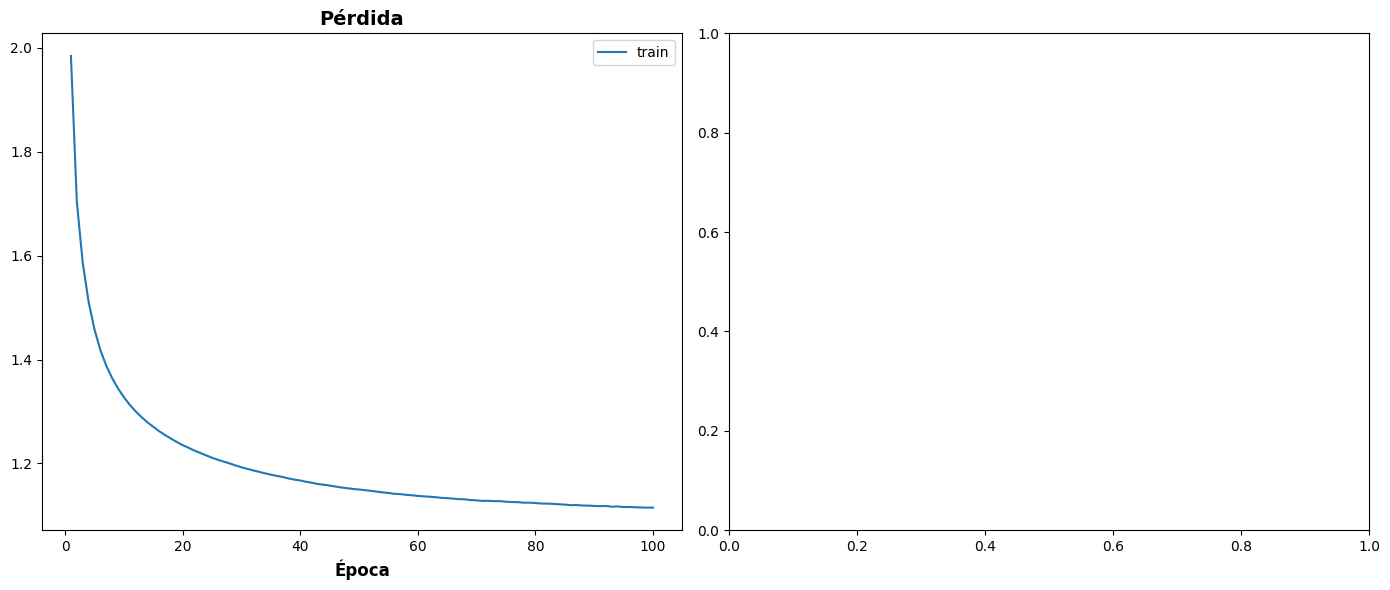

In [ ]:
graficar_historial_entrenamiento(historial_cc)

Durante el entrenamiento del modelo carácter a carácter, se observa que a la época 80 el valor de la función de pérdida (loss) alcanza aproximadamente 1.1, y al llegar a la época 100 disminuye levemente a 1.0. Esta evolución indica que, aunque el modelo continúa aprendiendo, la tasa de mejora se vuelve muy lenta en las últimas 20 épocas. En otras palabras, después de la época 80, la curva de pérdida se estabiliza y las ganancias adicionales en rendimiento son mínimas. Por esta razón, detener el entrenamiento anticipadamente, por ejemplo, en la época 80, no sería una mala decisión, ya que se evitaría un consumo innecesario de tiempo y recursos computacionales, sin perder calidad significativa en el modelo. Esta situación es típica en tareas de generación de texto, donde después de cierto punto el modelo ya ha captado los patrones principales del lenguaje y las mejoras posteriores tienden a ser marginales. Implementar un mecanismo como EarlyStopping podría automatizar esta decisión, terminando el entrenamiento cuando la mejora del loss deja de ser significativa.

Este bloque de código implementa la generación de texto utilizando el modelo entrenado carácter a carácter. Para hacerlo, se recibe una semilla inicial de texto (seed_text) y va prediciendo, paso a paso, los caracteres siguientes para construir una secuencia nueva.

Para seleccionar el siguiente carácter a predecir, se emplea una técnica llamada muestreo con temperatura. Esta técnica permite controlar la aleatoriedad de las predicciones: con temperaturas bajas, las predicciones son más conservadoras y repetitivas, mientras que con temperaturas altas se generan resultados más variados y creativos.

El proceso consiste en tomar la última parte del texto generado, codificarla en formato one-hot para que el modelo pueda procesarla, y luego obtener la probabilidad de cada posible siguiente carácter. A partir de estas probabilidades y usando el muestreo con temperatura, se elige un carácter que se añade al texto generado, repitiendo este ciclo hasta completar la longitud deseada.

Este método es útil para observar cómo el modelo aprendido puede crear secuencias coherentes de texto y para experimentar con la creatividad y diversidad del lenguaje generado ajustando la temperatura.

In [ ]:
def ej_temp(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generar_txtmodelo(model, seed_text, caracteres_indices, idx2char, seq_length, num_chars=200, temperature=1.0):
    generated = seed_text

    for _ in range(num_chars):
        input_seq = generated[-seq_length:]
        input_indices = [caracteres_indices.get(c, 0) for c in input_seq]

        if len(input_indices) < seq_length:
            input_indices = [0] * (seq_length - len(input_indices)) + input_indices

        # One-hot encoding para el modelo carácter a carácter
        x_pred = np.zeros((1, seq_length, len(caracteres_indices)))
        for t, idx in enumerate(input_indices):
            x_pred[0, t, idx] = 1.0

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = ej_temp(preds, temperature)
        next_char = idx2char[next_index]

        generated += next_char

    return generated

La siguiente función genera y muestra texto a partir de diferentes frases semilla utilizando el modelo entrenado. Para cada semilla, se generan textos con distintas temperaturas, lo que permite observar cómo la variación en la aleatoriedad afecta la creatividad y coherencia del texto generado. Así, se evalúa el comportamiento del modelo bajo diferentes configuraciones de muestreo.

In [ ]:
def predicciones(model, caracteres_indices, idx2char, seq_length):
    frases = [
        "en un lugar de la man",
        "don quijo",
        "el caballe"
    ]

    temperaturas = [0.2, 0.5, 1.0]

    for frase in frases:
        print(f"Semilla: '{frase}'\n")
        for temp in temperaturas:
            texto_generado = generar_txtmodelo(
                model=model,
                seed_text=frase,
                caracteres_indices=caracteres_indices,
                idx2char=idx2char,
                seq_length=seq_length,
                num_chars=200,
                temperature=temp
            )
            print(f"Con temperatura {temp}: {texto_generado}\n")

En esta sección, se crea un diccionario inverso para mapear índices a caracteres, facilitando la interpretación de las predicciones del modelo. Luego, se ejecuta la función de predicción con el modelo entrenado y las configuraciones definidas, para generar texto a partir de las frases semilla y analizar los resultados.

In [ ]:
# Diccionarios necesarios
idx2char = {i: c for c, i in caracteres_indices.items()}

# Ejecutar evaluación
predicciones(modelo_c_c, caracteres_indices, idx2char, SEQ_LENGTH)

Semilla: 'en un lugar de la man'

Con temperatura 0.2: en un lugar de la mano de su amo que en la mano y el senor don quijote que el caballero de la mancha procuraba en la mano y asi lo hay alguna cosa que esta a su amo ni es de donde se le acordaba de don quijote y en dios y

Con temperatura 0.5: en un lugar de la mano de don quijote un caso  eso no lo que le habian de pasan y deste mil deseos de la mano de don quijote la vida y con todo eso me parecio en la male vino a mi como lo es de aquella sala de don quijote

Con temperatura 1.0: en un lugar de la manera rey dado chilluia por un lubir a la cortesana y mas enemigo de desencertarme no te hubies y asi fino se llama el layo el cual vive mas que el tepia cuentan respondio  le puspo algun estribo impest

Semilla: 'don quijo'

Con temperatura 0.2: don quijote que en esto se le acaba en el cual se le dijo  de mi parte la memoria y a la cabeza que se le dejara en el se ponia a su amo ni es de donde estaban los que estaba de ser senor don

Las predicciones generadas por el modelo carácter a carácter muestran cómo la temperatura afecta directamente la coherencia, creatividad y variabilidad del texto.

En la temperatura baja (0.2), el modelo genera texto bastante coherente y fluido, pero con repeticiones evidentes. Por ejemplo, en la primera semilla, la frase “en la mano y el señor don Quijote” se repite varias veces casi igual, lo que indica que el modelo elige las opciones más probables y seguras. Esto hace que el texto sea más predecible y limitado en variedad.

A medida que aumentamos la temperatura a 0.5, el texto comienza a ser más diverso y creativo, aunque mantiene un nivel aceptable de coherencia. Aquí el modelo explora opciones menos obvias, generando frases más variadas y con un poco más de riqueza en el contenido.

Cuando la temperatura se eleva a 1.0, el texto generado se vuelve mucho más impredecible y arriesgado, con oraciones que pueden perder sentido o contener errores, pero aportan mayor variedad y sorpresa. Esta opción puede ser útil cuando se busca generar ideas o frases menos comunes, aunque con menor precisión.

Estos resultados muestran cómo ajustando la temperatura permite controlar la creatividad del modelo: temperaturas bajas son útiles para aplicaciones donde se busca alta coherencia y precisión (como autocompletado o corrección), mientras que temperaturas más altas pueden servir para generar textos más variados o creativos, aunque menos predecibles. Esto es clave para adaptar el modelo a distintas tareas de NLP según la necesidad.

##Modelo 2 - Cambio batch size

En esta segunda etapa, se mantiene la misma arquitectura del modelo carácter a carácter basada en una capa LSTM de 128 unidades seguida de una capa densa con activación softmax para predecir el siguiente carácter. Sin embargo, se modifica un hiperparámetro: el tamaño del lote (batch size), que se incrementa de 128 a 256.

Este cambio se realiza con el objetivo de evaluar cómo afecta el tamaño del batch al proceso de entrenamiento y al desempeño del modelo. Un batch size mayor puede mejorar la estabilidad y velocidad del entrenamiento al procesar más datos por iteración, aunque también puede impactar en la capacidad del modelo para generalizar. Por ello, se reentrena el modelo con este ajuste y se analiza su comportamiento para decidir cuál configuración es más adecuada para esta tarea de generación de texto.

In [ ]:
modelo_c_c2 = crear_modelo(SEQ_LENGTH, len(caracteres_indices), "Batch_size256")
modelo_c_c2.summary()

Model: "Batch_size256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CapaLSTM (LSTM)                 │ (None, 128)            │        83,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Densa (Dense)                   │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,842 (343.13 KB)

 Trainable params: 87,842 (343.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historial_cc2 = modelo_c_c2.fit(X, y, batch_size=256, epochs=100)

Epoch 1/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 2.3361
Epoch 2/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.8453
Epoch 3/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.7289
Epoch 4/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.6480
Epoch 5/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.5923
Epoch 6/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.5411
Epoch 7/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.5018
Epoch 8/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.4678
Epoch 9/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.4451
Epoch 10/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.4248
Epoch 11/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.4055
Epoch 12/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.3877
Epoch 13/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.3768
Epoch 14/100
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.3577
E

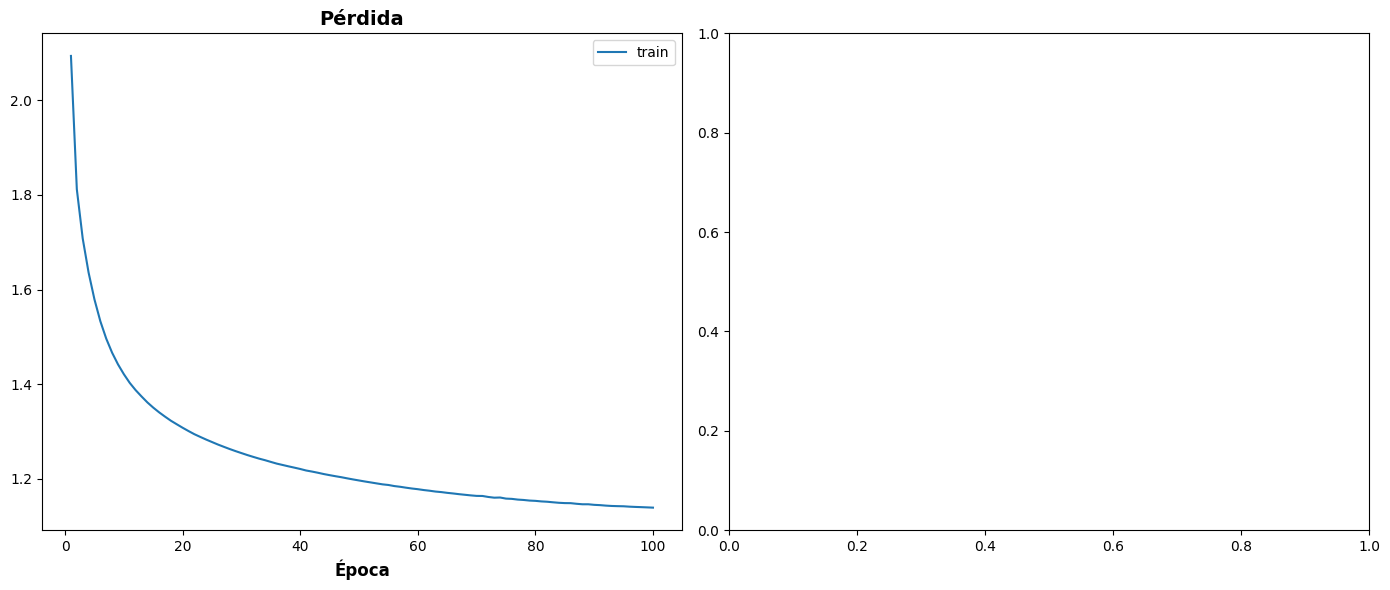

In [ ]:
graficar_historial_entrenamiento(historial_cc2)

El ajuste del batch size a un valor mayor tuvo un impacto claro en la forma en que el modelo aprendió a lo largo del entrenamiento. Al emplear un tamaño de batch de 256, el modelo mostró una convergencia más estable, con una curva de pérdida que disminuye de manera más suave y progresiva. Esto se debe a que, con un mayor número de muestras en cada actualización, el gradiente calculado es más representativo, lo que reduce la variabilidad en las actualizaciones de los pesos. Si bien esta estabilidad favorece una trayectoria de aprendizaje más consistente, también tiende a limitar la capacidad del modelo para capturar patrones más específicos y sutiles de los datos. En comparación con el modelo anterior, que usó un batch size de 128, se observa que la pérdida final es ligeramente más alta, lo que indica que el ajuste logrado fue algo menos preciso.

Desde el punto de vista de la eficiencia, el aumento del batch size permitió reducir el tiempo por época, aprovechando de mejor forma los recursos computacionales, especialmente cuando se utiliza una GPU. Esta mejora en el rendimiento computacional hizo posible completar cada época en menor tiempo, contribuyendo a una mayor rapidez del entrenamiento. Sin embargo, este beneficio viene acompañado de una pequeña pérdida en la capacidad del modelo para generalizar. Aunque el modelo con batch size 256 logra reducir consistentemente la pérdida a lo largo del entrenamiento, se puede observar que la curva comienza a estabilizarse desde épocas relativamente tempranas, alrededor de la época 40. A partir de ese punto, las disminuciones en la pérdida se vuelven más lentas y graduales, manteniéndose en torno a valores entre 1.14 y 1.13 hacia el final del entrenamiento. Esta estabilización anticipada sugiere que el modelo llegó rápidamente a un punto cercano al mínimo de la función de pérdida, pero sin la misma capacidad de ajuste fino que mostró el modelo anterior. En contraste, el modelo con batch size 128 continuaba ajustándose de forma más activa incluso pasadas las 60 épocas, lo que refleja una mayor sensibilidad a los datos y una convergencia más flexible.

En conjunto, este experimento evidencia cómo el batch size actúa como un hiperparámetro crítico que afecta directamente el equilibrio entre la velocidad de entrenamiento y la capacidad de ajuste del modelo. Un tamaño de lote mayor ofrece ventajas en términos de eficiencia, pero puede limitar la precisión del aprendizaje, especialmente en tareas donde los matices del lenguaje, como en la generación de texto carácter a carácter, requieren ajustes más detallados. Por lo tanto, la elección del batch size debe considerar tanto los objetivos del modelo como las capacidades del entorno de entrenamiento.

In [ ]:
predicciones(modelo_c_c2, caracteres_indices, idx2char, SEQ_LENGTH)

Semilla: 'en un lugar de la man'

Con temperatura 0.2: en un lugar de la mano y esto de la mano y de los mas de la sangre y asi le dijo  deshora de la caballeria a la parte de la mancha que tenia a la mujer de la mancha      capitulo xvii taldida con el de la mano y el caso d

Con temperatura 0.5: en un lugar de la mano el cual el palabras por mas libros y aunque mas a mi desgracia en la mano y dijo don quijote que viene en efcones de la casta que se debe de don quijote y de la barba y asi me lo que se tuvo en el c

Con temperatura 1.0: en un lugar de la mano pues todo sin comilaba que no tendria de segun el maes ligera  se le barro ya le parecio admir yo dar para otro al boca y conoce el juego la enemigo que pudiese por sus abrandas con vuestra ventura 

Semilla: 'don quijo'

Con temperatura 0.2: don quijosegres a descaisa de la mano y asi es dijo don quijote y por lo que se le parecia en el mundo y no tan a su casa y de los caballero que el castillo verdadera y si el estaba de mi alm

Las predicciones del modelo entrenado con un batch size aumentado a 256 muestran un cambio importante en el equilibrio entre coherencia y variabilidad al generar texto, especialmente al compararlo con el modelo con batch size 128.

A temperatura 0.2, este modelo tiende aún más a la repetición, pero con un deterioro en la calidad del texto. En lugar de generar frases ordenadas como “en la mano y el señor don Quijote” (observadas en el modelo anterior), ahora repite combinaciones como “de la mano y de la mancha” o “el caballero de la cabeza”, que aunque son sintácticamente válidas, aparecen de forma reiterativa y con menor riqueza estructural. El lenguaje suena mecánico y poco flexible, mostrando que el modelo prefiere soluciones extremadamente seguras pero con menos diversidad y fluidez narrativa.

Con una temperatura de 0.5, la diferencia respecto al modelo anterior es más notoria. Si bien el primer modelo generaba frases variadas y coherentes como “el caballero que no hay amor después de haberle dicho de don Quijote”, este segundo modelo produce secuencias menos claras como “no se le pone en los caballeros andantes” o “yo le acortaban a descantamanaran el cura”. Las construcciones intentan introducir diversidad, pero presentan errores gramaticales, verbos mal conjugados o expresiones que carecen de lógica interna. Esto evidencia una pérdida de control estructural en el intento por generar contenido más creativo.

Cuando subimos a temperatura 1.0, la generación se vuelve mucho más inestable que en el primer modelo. En lugar de frases creativas pero comprensibles, como “el cual vive más que el tepia cuentan” (del modelo 128), aquí aparecen palabras completamente inventadas o mal formadas, como “comilaba”, “auchado al mundo”, o “arnelaciose”. El texto pierde su forma narrativa casi por completo, y las secuencias son difíciles de interpretar, señal de que el modelo no logra mantener el equilibrio entre aleatoriedad y estructura cuando se le exige mayor flexibilidad.

En resumen, aunque ambos modelos responden a la temperatura de forma predecible, el modelo con batch size de 256 muestra menor capacidad de generalización y peor manejo del lenguaje. Esto se refleja especialmente en su mayor rigidez a temperaturas bajas y su desorganización a temperaturas altas. El cambio de batch size, si bien puede mejorar la eficiencia computacional durante el entrenamiento, reduce la precisión en la adaptación a patrones finos del lenguaje, lo que se traduce en textos menos coherentes y de menor calidad narrativa en tareas de generación carácter a carácter.

##Modelo 3 - Cambio en arquitectura

En esta nueva iteración del modelo, el principal cambio implementado consiste en modificar la arquitectura base utilizando una capa LSTM bidireccional. Mientras que en los modelos anteriores la red procesaba el texto únicamente en una dirección (de izquierda a derecha), ahora se incorpora una capa Bidirectional que permite a la red recorrer la secuencia tanto hacia adelante como hacia atrás. Esta modificación tiene como objetivo proporcionar al modelo un mayor contexto a la hora de predecir el siguiente carácter, ya que ahora puede considerar tanto lo que viene antes como lo que sigue a cada posición de la secuencia en entrenamiento.

Para asegurar que los resultados sean comparables con los 2 modelos anteriores, se mantuvo el batch size en 128 y el número de épocas en 100, replicando las mismas condiciones de entrenamiento y así poder evaluar el impacto exclusivo del cambio arquitectónico. La arquitectura completa incluye una primera capa LSTM bidireccional con return_sequences=True, seguida de una segunda capa LSTM unidireccional que procesa la secuencia completa, y finalmente una capa densa con activación softmax para predecir la distribución de probabilidad del siguiente carácter. Este diseño permite capturar dependencias más complejas en el texto, lo cual es especialmente valioso en el modelado de lenguaje carácter a carácter.

El motivo de este cambio arquitectónico es mejorar la calidad narrativa y la coherencia contextual del texto generado, enfrentando una limitación común en modelos unidireccionales: su dependencia exclusiva de la información previa. Al utilizar una capa bidireccional, el modelo ahora puede analizar cada carácter considerando tanto lo que viene antes como lo que viene después dentro de la secuencia de entrada, lo que le permite hacer predicciones más informadas y precisas. Esta doble perspectiva ayuda a capturar patrones más complejos y contextos simétricos, lo cual resulta especialmente útil en tareas de modelado de lenguaje carácter a carácter.

In [ ]:
def crear_modelo2(seq_length, vocab_size, model_name):
    input_len = seq_length
    model = tf.keras.models.Sequential(name=model_name)
    model.add(tf.keras.layers.Input(shape=(input_len, vocab_size), name="Entrada"))
    model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
    model.add(tf.keras.layers.LSTM(128, name="CapaLSTM"))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="Salida"))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [ ]:
modelo_c_c3 = crear_modelo2(SEQ_LENGTH, len(caracteres_indices), "Bidireccional")
modelo_c_c3.summary()

Model: "Bidireccional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       166,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CapaLSTM (LSTM)                 │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Salida (Dense)                  │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,418 (1.41 MB)

 Trainable params: 368,418 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historial_cc3 = modelo_c_c3.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 2.0900
Epoch 2/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.5321
Epoch 3/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.3940
Epoch 4/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 1.3252
Epoch 5/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.2771
Epoch 6/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.2384
Epoch 7/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.2146
Epoch 8/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.1906
Epoch 9/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 1.1698
Epoch 10/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.1489
Epoch 11/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.1335
Epoch 12/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.1164
Epoch 13/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.1048
Epoch 14/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - 

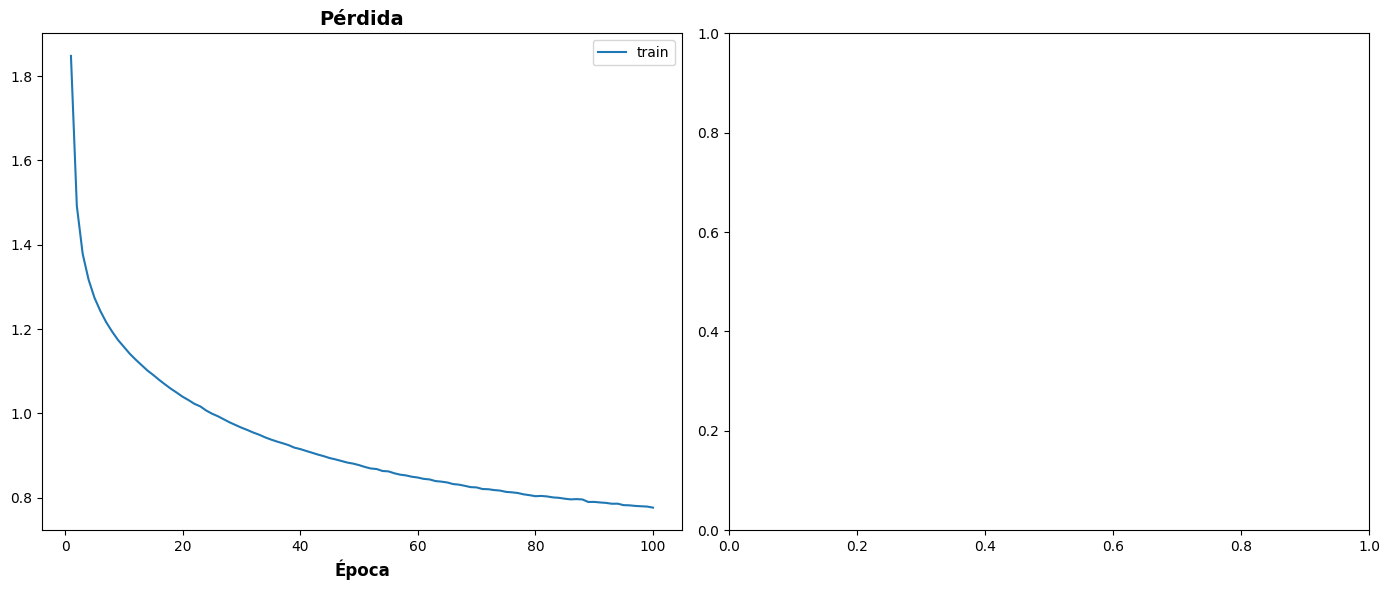

In [ ]:
graficar_historial_entrenamiento(historial_cc3)

El gráfico de pérdida del modelo 3 evidencia una mejora sostenida a lo largo de las 100 épocas. Este comportamiento representa la curva más estable y profunda de los tres modelos entrenados, superando en resultado final al modelo original y al modelo con batch size aumentado, ya que ha sido el que ha entregado la pérdida más baja.

En comparación con el modelo 1, que también fue entrenado con 100 épocas y batch size 128, la nueva arquitectura logra una pérdida mucho más baja. Mientras que el modelo 1 alcanzaba un valor cercano a 1.1 al final del entrenamiento, el modelo bidireccional desciende de forma más prolongada y consistente hasta valores inferiores, lo que indica una mejor capacidad para minimizar el error en la predicción de los caracteres.

Respecto al modelo 2 (con batch size 256), la diferencia es aún más notoria. En ese caso, la pérdida comenzaba también en torno a 2.0, pero se estabilizaba prematuramente, sin alcanzar el mismo nivel, lo que sugería una convergencia más rápida pero menos precisa.

Este mejor desempeño puede atribuirse directamente a la arquitectura bidireccional, que permite al modelo aprovechar información contextual tanto hacia adelante como hacia atrás en la secuencia. Al tener una comprensión más completa del entorno de cada carácter, la red es capaz de hacer predicciones más acertadas, lo que se refleja en una menor pérdida. Además, el regreso al batch size de 128 permitió mantener una mayor frecuencia de actualizaciones de los pesos, contribuyendo a una optimización más fina del modelo.

En definitiva, los resultados obtenidos respaldan la efectividad del cambio arquitectónico y justifican su implementación, ya que contribuye de manera significativa a mejorar la capacidad del modelo para comprender y generar lenguaje carácter a carácter con mayor coherencia y precisión

In [ ]:
predicciones(modelo_c_c3, caracteres_indices, idx2char, SEQ_LENGTH)

Semilla: 'en un lugar de la man'

Con temperatura 0.2: en un lugar de la mancha      capitulo xxvi dono se sirvian estas traen las costillas son las del agua de la memoria      capitulo xxvi dono quiso dicho perdona la causa de su amo y con estremo le dijo  si aqui estuviera 

Con temperatura 0.5: en un lugar de la mancha castellano y todos los demas estaban estos pajarias y desde alli el corazon que se quede en lo que se detuviera a la mujeridad de los de su amo que no le habia dicho por ver que siempre la via ser

Con temperatura 1.0: en un lugar de la mancha a sus sucesos que despues autorededes que escuchad estos edieros de una palma de batanco y parece que viva el aunque escudero  senor de la inmantinada verdad y trazas asi era tanto especialmente d

Semilla: 'don quijo'

Con temperatura 0.2: don quijote a todos los destas cosas que el caso que esta a la mujeridad de la caballeria andante caballero andante que ya esta en el mundo que es el caso que el diablo le dijo  de la vida y 

Las predicciones generadas muestran una mejora clara en la fluidez y cohesión del texto, en especial cuando se comparan con las producciones anteriores. A temperatura baja (0.2), el modelo produce frases bastante estructuradas, incluso más ricas que las de las versiones previas. Por ejemplo, en la semilla “en un lugar de la man”, genera fragmentos con sentido narrativo, que, aunque un poco repetitivo, mantiene una forma coherente y con referencias típicas del estilo original del texto.

Con una temperatura intermedia (0.5), el texto conserva un nivel razonable de coherencia, pero gana variedad y creatividad. Las frases muestran cómo el modelo ahora es capaz de combinar elementos narrativos con más libertad, sin caer en incoherencias tan graves como en versiones anteriores. Si bien surgen algunas expresiones inusuales o neologismos (“mujeridad”), el estilo sigue siendo reconocible y se asemeja a un español literario típico.

A temperatura alta (1.0), el modelo despliega una mayor libertad creativa, pero sorprendentemente mantiene mejor la sintaxis general que en versiones anteriores. A pesar de introducir expresiones como “autorededes” o “la inmantinada verdad”, el texto sigue cierto ritmo literario, e incluso conserva elementos temáticos recurrentes de la obra. Esto sugiere que el nuevo modelo logra equilibrar mejor variedad y estructura, generando resultados menos caóticos y más “legibles” incluso bajo condiciones de mayor aleatoriedad.

En conjunto, estos resultados sugieren que la introducción de la bidireccionalidad permitió al modelo capturar dependencias más profundas dentro de las secuencias, mejorando su comprensión contextual y aumentando la diversidad de las predicciones sin sacrificar completamente la coherencia. Esto lo convierte en un cambio valioso para enriquecer la calidad del texto generado.

##Resumen Arquitectura de las redes

En la siguiente tabla se presenta una comparación detallada de los tres modelos de red neuronal desarrollados durante el proceso experimental. Cada configuración varía en uno o más aspectos clave, como el tipo de arquitectura (LSTM unidireccional o bidireccional), el tamaño del lote (batch size), y el número de capas. Todos los modelos se entrenaron durante 100 épocas, lo que permite una evaluación equilibrada en términos de tiempo de entrenamiento y exposición a los datos. La métrica utilizada para evaluar el desempeño fue la pérdida de entrenamiento (loss), representando el error que el modelo comete al predecir el siguiente carácter en la secuencia. A través de esta comparación estructural, se busca analizar cómo cada cambio impacta en la capacidad del modelo para aprender patrones complejos en el texto.

In [ ]:
modelos = [
    {
        'Nombre': 'Red_base','Capas LSTM': '1 (128)','Capas Bidirecionales': 'No','Capas Salida': '1 (34)','Epocas': '100', 'Batch Size': '128',
        **metricas(historial_cc)
    },
    {
        'Nombre': 'Cambio_batch','Capas LSTM': '1 (128)','Capas Bidirecionales': 'no','Capas Salida': '1 (34)','Epocas': '100', 'Batch Size': '256',
        **metricas(historial_cc2)
    },
    {
        'Nombre': 'Cambio_arquitectura','Capas LSTM': '2 (128)','Capas Bidirecionales': 'Si','Capas Salida': '1 (34)','Epocas': '100', 'Batch Size': '128',
        **metricas(historial_cc3)
    }
]

modelos_metr = pd.DataFrame(modelos)

modelos_metr

,Nombre,Capas LSTM,Capas Bidirecionales,Capas Salida,Epocas,Batch Size,Train Loss
0,Red_base,1 (128),No,1 (34),100,128,1.1150
1,Cambio_batch,1 (128),no,1 (34),100,256,1.1395
2,Cambio_arquitectura,2 (128),Si,1 (34),100,128,0.7762


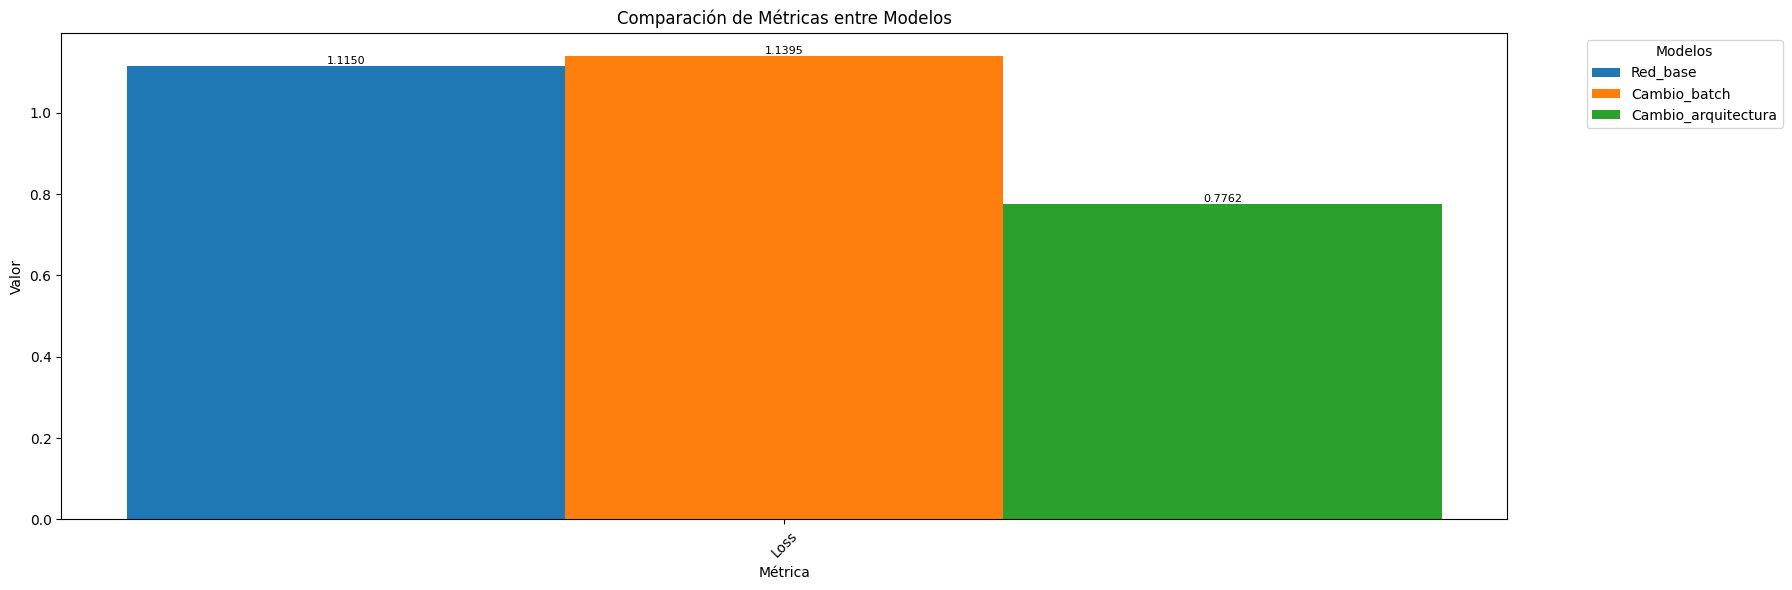

In [ ]:
historiales = [
    historial_cc.history,
    historial_cc2.history,
    historial_cc3.history
]

nombres_modelos = [
    'Red_base',
    'Cambio_batch',
    'Cambio_arquitectura'
]

df_resultado_2 = graficar_comparacion_modelos(historiales, nombres_modelos)

El gráfico de barras permite visualizar con claridad el efecto que tuvo cada ajuste arquitectónico y de hiperparámetros sobre la métrica loss. Como se observa, el modelo base (modelo 1) alcanzó una pérdida de 1.1150, mientras que al incrementar el batch size a 256 en el segundo modelo, el rendimiento se deterioró, alcanzando una pérdida mayor de 1.1395. En contraste, el modelo con arquitectura bidireccional mostró una mejora considerable, con una pérdida bastante menor de 0.7762. Este resultado evidencia que, más allá de los hiperparámetros, la arquitectura del modelo tiene un impacto directo sobre su capacidad de aprendizaje y generalización, siendo este el factor más determinante en este experimento.

##Mejor modelo

In [ ]:
modelos = [modelo_c_c, modelo_c_c2, modelo_c_c3]
historiales = [historial_cc.history, historial_cc2.history, historial_cc3.history]

loss = [h['loss'][-1] for h in historiales]

indice_mejor = loss.index(min(loss))

mejor_modelo = modelos[indice_mejor]
nombre_mejor_modelo = mejor_modelo.name
hist_mejor = historiales[indice_mejor]

print(f"Mejor modelo según menor Loss:")
print(f"Nombre: {nombre_mejor_modelo}")

print(f"Loss: {min(loss)}")

mejor_modelo.save("modelo_mejor.keras")

Mejor modelo según menor Loss:
Nombre: Bidireccional
Loss: 0.7761615514755249


Según el valor de pérdida más bajo alcanzado tras 100 épocas de entrenamiento, el modelo con arquitectura bidireccional fue seleccionado como el mejor modelo. Esta elección se fundamenta en el objetivo de minimizar el error en la predicción carácter a carácter. A pesar de haber mantenido la misma cantidad de datos, el mismo número de épocas y el mismo batch size que el modelo base, la incorporación de una capa LSTM bidireccional resultó en una pérdida final notablemente más baja, lo que demuestra una mejora significativa en el aprendizaje del modelo.

##Conclusiones

La comparación entre los tres modelos desarrollados permite obtener conclusiones relevantes sobre el impacto que tienen los ajustes de arquitectura e hiperparámetros en el rendimiento de modelos LSTM aplicados a tareas de generación de texto carácter a carácter. Desde el inicio, se optó por utilizar LSTM en lugar de RNN simples debido a su capacidad superior para recordar y utilizar información importante que ocurrió muchos pasos atrás en la secuencia, evitando los problemas asociados al desvanecimiento del gradiente, lo cual es esencial en la generación de lenguaje natural.

El modelo base, con una configuración estándar de una sola capa LSTM y batch size de 128, logró una pérdida final de 1.1150, sirviendo como punto de referencia. Posteriormente, al aumentar el batch size a 256 en el segundo modelo, se observó un empeoramiento del rendimiento con una pérdida de 1.1395. Esta diferencia puede explicarse porque, con un batch más grande, el modelo actualiza sus pesos con menor frecuencia durante cada época, lo que reduce su capacidad de adaptación fina a patrones específicos del texto. Si bien un batch grande puede estabilizar el entrenamiento, en este caso afectó negativamente la precisión del aprendizaje.

En la tercera iteración, se mantuvieron constantes tanto el número de épocas como el batch size original (128), pero se introdujo un cambio arquitectónico: la incorporación de una capa LSTM bidireccional seguida de una capa LSTM unidireccional. Este cambio permitió al modelo capturar mejor las relaciones contextuales tanto anteriores como posteriores dentro de cada secuencia, lo que se tradujo en una pérdida final mucho más baja (0.7762). Esta mejora en la métrica de evaluación, valida el beneficio de enriquecer la arquitectura, más allá de simplemente ajustar hiperparámetros como el tamaño del batch.

En resumen, especifícamente en esta experimentación, se demuestra que las decisiones arquitectónicas tienen un impacto más profundo en la eficacia del modelo que un ajustes de hiperparámetros como el batch size. Además, se confirma que mantener un batch moderado permite una mejor adaptación durante el entrenamiento, especialmente cuando se trabaja con secuencias largas y complejas. La arquitectura bidireccional, en combinación con una configuración de entrenamiento estable (batch 128, 100 épocas), representa la opción más efectiva para esta tarea. Por tanto, el modelo final no solo se justifica por su métrica más baja, sino también por su mayor capacidad para aprender patrones contextuales complejos de manera eficiente, como pudimos verlo en las predicciones de cada uno de los modelos.

##Modelo 4 - Regularización

Finalmente, se intentó una cuarta modificación que incorporó una capa de regularización (Dropout) con el objetivo de reducir aún más la pérdida y generar predicciones más coherentes. Aunque el entrenamiento logró completarse a 99 épocas, las limitaciones de recursos impidieron generar las visualizaciones correspondientes. No obstante, la evolución del loss mostró una tendencia estable y consistente, alcanzando un valor final de 0.8913, lo que indica un rendimiento competitivo respecto a los modelos anteriores. Si bien este modelo no superó al modelo bidireccional sin regularización, la incorporación de técnicas como Dropout puede resultar útil para mejorar la capacidad de generalización en contextos más complejos o con datos ruidosos. Se deja así constancia de este intento como una posible línea de mejora futura.

In [ ]:
def crear_modelo3(seq_length, vocab_size, model_name):
    input_len = seq_length
    model = tf.keras.models.Sequential(name=model_name)
    model.add(tf.keras.layers.Input(shape=(input_len, vocab_size), name="Entrada"))
    model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), name="Bidirecional"))
    model.add(tf.keras.layers.LSTM(128, name="CapaLSTM"))
    model.add(tf.keras.layers.Dropout(0.2, name="Dropout"))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="Salida"))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [ ]:
modelo_c_c4 = crear_modelo3(SEQ_LENGTH, len(caracteres_indices), "Caracter-Caracter")
modelo_c_c4.summary()

Model: "Caracter-Caracter"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bidirecional (Bidirectional)    │ (None, 30, 256)        │       166,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CapaLSTM (LSTM)                 │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Salida (Dense)                  │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,418 (1.41 MB)

 Trainable params: 368,418 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historial_cc4 = modelo_c_c4.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 2.1035
Epoch 2/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 1.5510
Epoch 3/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.4182
Epoch 4/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.3478
Epoch 5/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.3072
Epoch 6/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 1.2738
Epoch 7/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 1.2478
Epoch 8/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 1.2241
Epoch 9/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.2083
Epoch 10/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 1.1890
Epoch 11/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 1.1782
Epoch 12/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 1.1649
Epoch 13/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 1.1530
Epoch 14/100
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - 

In [ ]:
graficar_historial_entrenamiento(historial_cc3)

In [ ]:
predicciones(modelo_c_c3, caracteres_indices, idx2char, SEQ_LENGTH)